# **FL PIPELINE on MNIST dataset**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import copy
from torch.utils.data import Subset
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix
)
import torch.nn.functional as F

### **CNN for MNIST**

In [2]:
class MNISTMLP(nn.Module):
    def __init__(self, input_size=28*28, mlp_hidden=256, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, mlp_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(mlp_hidden, mlp_hidden//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(mlp_hidden//2, num_classes),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten 1×28×28 → 784
        return self.net(x)

### **Importing necessary fuctions from the pipeline**

##### Train local model function

In [3]:
def train_local_model(client_dataloader, model, pos_weight, epochs=5, lr=1e-3, device='cpu'):
    model.train().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # multiclass for MNIST
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(epochs):
        for Xb, yb in client_dataloader:
            Xb, yb = Xb.to(device), yb.to(device).long().view(-1)
            optimizer.zero_grad()
            logits = model(Xb)
            loss   = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

    return model


def evaluate_model(model, client_dataloader, pos_weight, device='cpu'):
    model.eval().to(device)
    loss_fn = nn.CrossEntropyLoss()

    total_loss, total_samples = 0.0, 0
    all_preds, all_labels      = [], []

    with torch.no_grad():
        for Xb, yb in client_dataloader:
            Xb, yb = Xb.to(device), yb.to(device).long().view(-1)
            logits = model(Xb)
            loss   = loss_fn(logits, yb)

            total_loss   += loss.item() * yb.size(0)
            total_samples+= yb.size(0)

            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.cpu().numpy())

    avg_loss = total_loss / total_samples
    avg_acc  = np.mean(np.array(all_preds) == np.array(all_labels))
    return avg_loss, avg_acc, all_preds, all_labels

##### FedAvg function

In [4]:
def federated_averaging(global_model,
                        train_loaders,
                        test_loaders,
                        pos_weights=None,
                        num_rounds=10,
                        epochs=5,
                        lr=1e-4,
                        device='cpu'):
    num_clients = len(train_loaders)
    sizes       = [len(dl.dataset) for dl in train_loaders]
    total_size  = sum(sizes)

    history      = {'loss': [], 'acc': []}
    per_client   = {'loss': {i:[] for i in range(num_clients)},
                    'acc' : {i:[] for i in range(num_clients)}}

    for rnd in range(1, num_rounds+1):
        print(f"\n=== FedAvg Round {rnd}/{num_rounds} ===")
        local_models = []

        for i in range(num_clients):
            local   = copy.deepcopy(global_model)
            trained = train_local_model(train_loaders[i], local,
                                        pos_weights[i] if pos_weights else None,
                                        epochs, lr, device)
            local_models.append(trained)

        with torch.no_grad():
            for p in global_model.parameters(): p.data.zero_()
            for i, loc in enumerate(local_models):
                weight = sizes[i] / total_size
                for gp, lp in zip(global_model.parameters(), loc.parameters()):
                    gp.data += weight * lp.data

        losses, accs = [], []
        for i in range(num_clients):
            loss, acc, _, _ = evaluate_model(global_model,
                                             test_loaders[i],
                                             pos_weights[i] if pos_weights else None,
                                             device)
            print(f" Client {i+1} → loss {loss:.4f}, acc {acc:.4f}")
            per_client['loss'][i].append(loss)
            per_client['acc'][i].append(acc)
            losses.append(loss); accs.append(acc)

        history['loss'].append(np.mean(losses))
        history['acc' ].append(np.mean(accs))
        print(f" → GLOBAL avg loss {history['loss'][-1]:.4f}, acc {history['acc'][-1]:.4f}")

    return global_model, history, per_client

##### FedProx function

In [5]:
def train_local_model_fedprox(client_dataloader, model, global_model,
                              pos_weight, mu=0.01, epochs=5, lr=1e-4, device='cpu'):
    model.train().to(device)
    global_model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    loss_fn = nn.CrossEntropyLoss()
    global_params = [p.detach().clone() for p in global_model.parameters()]

    for _ in range(epochs):
        for Xb, yb in client_dataloader:
            Xb, yb = Xb.to(device), yb.to(device).long().view(-1)
            optimizer.zero_grad()
            logits = model(Xb)
            loss   = loss_fn(logits, yb)

            prox = sum(torch.sum((p - gp.to(device))**2)
                       for p, gp in zip(model.parameters(), global_params))
            loss = loss + (mu/2)*prox

            loss.backward()
            optimizer.step()

    return model

In [6]:
def federated_averaging_prox(global_model, train_loaders, test_loaders,
                             pos_weights=None,
                             num_rounds=10, mu=0.01, epochs=5, lr=1e-4,
                             device='cpu'):
    num_clients = len(train_loaders)
    sizes       = [len(dl.dataset) for dl in train_loaders]
    total_size  = sum(sizes)

    history    = {'loss': [], 'acc': []}
    per_client = {'loss':{i:[] for i in range(num_clients)},
                  'acc' :{i:[] for i in range(num_clients)}}

    for rnd in range(1, num_rounds+1):
        print(f"\n=== FedProx Round {rnd}/{num_rounds} ===")
        local_models = []
        for i in range(num_clients):
            local = copy.deepcopy(global_model)
            trained = train_local_model_fedprox(train_loaders[i],
                                                local,
                                                global_model,
                                                pos_weights[i] if pos_weights else None,
                                                mu, epochs, lr, device)
            local_models.append(trained)

        with torch.no_grad():
            for p in global_model.parameters(): p.data.zero_()
            for i, loc in enumerate(local_models):
                weight = sizes[i] / total_size
                for gp, lp in zip(global_model.parameters(), loc.parameters()):
                    gp.data += weight * lp.data

        losses, accs = [], []
        for i in range(num_clients):
            loss, acc, _, _ = evaluate_model(global_model,
                                             test_loaders[i],
                                             pos_weights[i] if pos_weights else None,
                                             device)
            print(f" Client {i+1} → loss {loss:.4f}, acc {acc:.4f}")
            per_client['loss'][i].append(loss)
            per_client['acc'][i].append(acc)
            losses.append(loss); accs.append(acc)

        history['loss'].append(np.mean(losses))
        history['acc' ].append(np.mean(accs))
        print(f" → GLOBAL avg loss {history['loss'][-1]:.4f}, acc {history['acc'][-1]:.4f}")

    return global_model, history, per_client

### **Running everything together**

In [7]:
def load_and_prepare_data_MNIST(num_clients=2,
                                batch_size=32,
                                test_split=0.2,
                                random_state=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    full_train = datasets.MNIST('data', train=True, download=True, transform=transform)
    idx = np.random.RandomState(random_state).permutation(len(full_train))
    clients = np.array_split(idx, num_clients)

    train_loaders, test_loaders = [], []
    for c in clients:
        split = int(len(c)*(1-test_split))
        tr, te = c[:split], c[split:]
        train_loaders.append(DataLoader(Subset(full_train, tr),
                                        batch_size=batch_size, shuffle=True))
        test_loaders.append( DataLoader(Subset(full_train, te),
                                        batch_size=batch_size, shuffle=False))

    return train_loaders, test_loaders, None, 28*28, 10

##### Plot functions

In [8]:
def plot_global_accuracy(history):
    rounds = range(1, len(history['acc'])+1)
    plt.figure(figsize=(6,4))
    plt.plot(rounds, history['acc'])
    plt.xlabel("Round"); plt.ylabel("Global accuracy")
    plt.title("Global accuracy over rounds")
    plt.ylim(0,1)
    plt.show()

def plot_global_loss(history):
    rounds = range(1, len(history['loss'])+1)
    plt.figure(figsize=(6,4))
    plt.plot(rounds, history['loss'])
    plt.xlabel("Round"); plt.ylabel("Global loss")
    plt.title("Global loss over rounds")
    plt.show()

#### Evaluation function

In [9]:
def evaluate_classification(model, loaders, device):
    model.eval().to(device)
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for loader in loaders:
            for Xb, yb in loader:
                Xb = Xb.to(device)
                logits = model(Xb)
                probs = F.softmax(logits, dim=1).cpu().numpy()
                all_probs.append(probs)
                all_labels.append(yb.numpy())
    all_probs  = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)

    # Predicted classes
    preds = all_probs.argmax(axis=1)

    # Precision / Recall / F1
    print("Classification report:\n")
    print(classification_report(all_labels, preds, digits=4))

    # Confusion matrix
    print("Confusion matrix:\n")
    print(confusion_matrix(all_labels, preds))

    # ROC-AUC (macro OvR)
    roc_auc = roc_auc_score(all_labels, all_probs,
                            multi_class='ovr', average='macro')
    # PR-AUC / average precision (macro)
    pr_auc  = average_precision_score(all_labels, all_probs,
                                      average='macro')

    print(f"ROC-AUC (macro OvR):       {roc_auc:.4f}")
    print(f"PR-AUC (avg precision):    {pr_auc:.4f}")
    print()

### **Run All**

### **Global model**

In [10]:
device = torch.device('mps')

train_loaders, test_loaders, pos_weights, input_size, num_classes = \
    load_and_prepare_data_MNIST(num_clients=2,
                                batch_size=32,
                                test_split=0.2,
                                random_state=42)

# build the global model with exactly the same MLP you used centrally
global_model = MNISTMLP(input_size, mlp_hidden=256, num_classes=num_classes).to(device)

### **Run FedAvg**

In [11]:
device = torch.device('mps')

train_loaders, test_loaders, pos_weights, input_size, num_classes = \
    load_and_prepare_data_MNIST(
        num_clients=2,
        batch_size=32,
        test_split=0.2,
        random_state=42
    )

# initialize and run FedAvg
fedavg_model = MNISTMLP(input_size, mlp_hidden=256, num_classes=num_classes).to(device)
fedavg_model, fedavg_hist, fedavg_client_hist = federated_averaging(
    fedavg_model,
    train_loaders,
    test_loaders,
    pos_weights=None,
    num_rounds=50,
    epochs=5,
    lr=1e-4,
    device=device,
) 


=== FedAvg Round 1/50 ===
 Client 1 → loss 0.2097, acc 0.9367
 Client 2 → loss 0.1780, acc 0.9472
 → GLOBAL avg loss 0.1938, acc 0.9419

=== FedAvg Round 2/50 ===
 Client 1 → loss 0.1424, acc 0.9563
 Client 2 → loss 0.1182, acc 0.9645
 → GLOBAL avg loss 0.1303, acc 0.9604

=== FedAvg Round 3/50 ===
 Client 1 → loss 0.1136, acc 0.9667
 Client 2 → loss 0.0948, acc 0.9713
 → GLOBAL avg loss 0.1042, acc 0.9690

=== FedAvg Round 4/50 ===
 Client 1 → loss 0.1002, acc 0.9683
 Client 2 → loss 0.0829, acc 0.9747
 → GLOBAL avg loss 0.0916, acc 0.9715

=== FedAvg Round 5/50 ===
 Client 1 → loss 0.0921, acc 0.9728
 Client 2 → loss 0.0747, acc 0.9762
 → GLOBAL avg loss 0.0834, acc 0.9745

=== FedAvg Round 6/50 ===
 Client 1 → loss 0.0873, acc 0.9750
 Client 2 → loss 0.0711, acc 0.9790
 → GLOBAL avg loss 0.0792, acc 0.9770

=== FedAvg Round 7/50 ===
 Client 1 → loss 0.0865, acc 0.9762
 Client 2 → loss 0.0712, acc 0.9782
 → GLOBAL avg loss 0.0789, acc 0.9772

=== FedAvg Round 8/50 ===
 Client 1 → lo

### **Run FedProx**

In [12]:
device = torch.device('mps')

# reuse the same data loaders & model signature
fedprox_model = MNISTMLP(input_size, mlp_hidden=256, num_classes=num_classes).to(device)
fedprox_model, fedprox_hist, fedprox_client_hist = federated_averaging_prox(
    fedprox_model,
    train_loaders,
    test_loaders,
    pos_weights=None,
    num_rounds=50,
    mu=0.01,
    epochs=5,
    lr=1e-4,
    device=device,
)


=== FedProx Round 1/50 ===
 Client 1 → loss 0.2368, acc 0.9317
 Client 2 → loss 0.2063, acc 0.9413
 → GLOBAL avg loss 0.2215, acc 0.9365

=== FedProx Round 2/50 ===
 Client 1 → loss 0.1603, acc 0.9512
 Client 2 → loss 0.1380, acc 0.9587
 → GLOBAL avg loss 0.1491, acc 0.9549

=== FedProx Round 3/50 ===
 Client 1 → loss 0.1297, acc 0.9602
 Client 2 → loss 0.1113, acc 0.9675
 → GLOBAL avg loss 0.1205, acc 0.9638

=== FedProx Round 4/50 ===
 Client 1 → loss 0.1103, acc 0.9670
 Client 2 → loss 0.0961, acc 0.9702
 → GLOBAL avg loss 0.1032, acc 0.9686

=== FedProx Round 5/50 ===
 Client 1 → loss 0.0995, acc 0.9705
 Client 2 → loss 0.0888, acc 0.9723
 → GLOBAL avg loss 0.0941, acc 0.9714

=== FedProx Round 6/50 ===
 Client 1 → loss 0.0940, acc 0.9728
 Client 2 → loss 0.0842, acc 0.9738
 → GLOBAL avg loss 0.0891, acc 0.9733

=== FedProx Round 7/50 ===
 Client 1 → loss 0.0871, acc 0.9747
 Client 2 → loss 0.0782, acc 0.9755
 → GLOBAL avg loss 0.0826, acc 0.9751

=== FedProx Round 8/50 ===
 Clien

### **Evaluation**

In [13]:
print("=== FedAvg Global Model Metrics ===\n")
evaluate_classification(fedavg_model, test_loaders, device)

=== FedAvg Global Model Metrics ===

Classification report:

              precision    recall  f1-score   support

           0     0.9898    0.9898    0.9898      1181
           1     0.9859    0.9947    0.9903      1331
           2     0.9775    0.9865    0.9820      1187
           3     0.9785    0.9710    0.9747      1171
           4     0.9855    0.9771    0.9813      1180
           5     0.9698    0.9787    0.9742      1082
           6     0.9820    0.9868    0.9844      1215
           7     0.9735    0.9881    0.9808      1265
           8     0.9930    0.9677    0.9802      1176
           9     0.9792    0.9719    0.9756      1212

    accuracy                         0.9815     12000
   macro avg     0.9815    0.9813    0.9813     12000
weighted avg     0.9815    0.9815    0.9815     12000

Confusion matrix:

[[1169    0    3    1    0    2    4    1    0    1]
 [   0 1324    4    1    0    0    0    2    0    0]
 [   0    1 1171    4    1    0    0    9    1    0]
 [

In [14]:
print("\n=== FedProx Global Model Metrics ===\n")
evaluate_classification(fedprox_model, test_loaders, device)


=== FedProx Global Model Metrics ===

Classification report:

              precision    recall  f1-score   support

           0     0.9840    0.9915    0.9878      1181
           1     0.9873    0.9910    0.9891      1331
           2     0.9758    0.9857    0.9807      1187
           3     0.9736    0.9778    0.9757      1171
           4     0.9862    0.9703    0.9782      1180
           5     0.9611    0.9824    0.9717      1082
           6     0.9826    0.9770    0.9798      1215
           7     0.9788    0.9866    0.9827      1265
           8     0.9853    0.9685    0.9768      1176
           9     0.9816    0.9662    0.9738      1212

    accuracy                         0.9798     12000
   macro avg     0.9796    0.9797    0.9796     12000
weighted avg     0.9799    0.9798    0.9798     12000

Confusion matrix:

[[1171    0    3    0    0    1    3    1    0    2]
 [   0 1319    5    2    0    1    0    3    1    0]
 [   0    0 1170    5    2    0    1    5    4    0]


## **Plots**

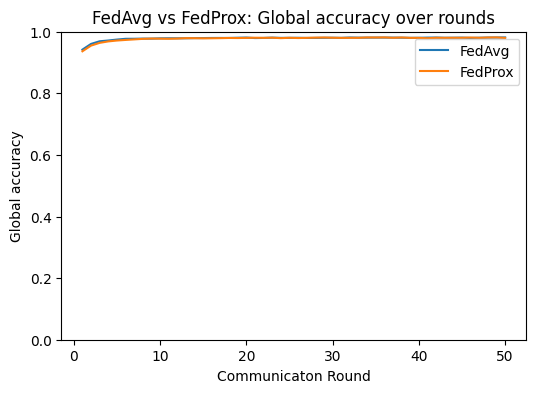

In [15]:
# Global Accuracy Comparison
plt.figure(figsize=(6,4))
rounds_avg = range(1, len(fedavg_hist['acc'])+1)
rounds_prox = range(1, len(fedprox_hist['acc'])+1)

plt.plot(rounds_avg,  fedavg_hist['acc'], label='FedAvg')
plt.plot(rounds_prox, fedprox_hist['acc'], label='FedProx')

plt.xlabel("Communicaton Round")
plt.ylabel("Global accuracy")
plt.title("FedAvg vs FedProx: Global accuracy over rounds")
plt.ylim(0,1)
plt.legend()
plt.show()

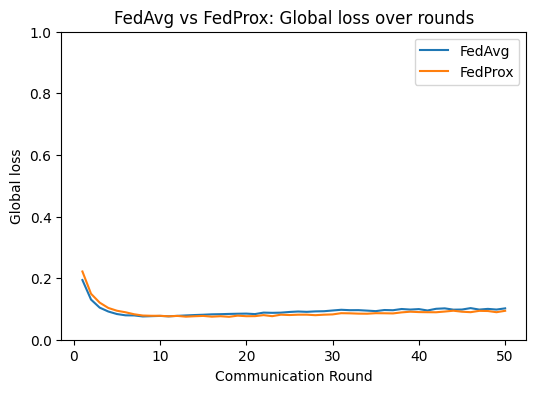

In [16]:
# Global Loss Comparison
plt.figure(figsize=(6,4))
plt.plot(rounds_avg,  fedavg_hist['loss'], label='FedAvg')
plt.plot(rounds_prox, fedprox_hist['loss'], label='FedProx')

plt.xlabel("Communication Round")
plt.ylabel("Global loss")
plt.title("FedAvg vs FedProx: Global loss over rounds")
plt.legend()
plt.ylim(0, 1)
plt.show()

### **Final Evaluation Metrics**

In [17]:
print("=== FedAvg Metrics ===")
evaluate_classification(fedavg_model, test_loaders, device)

=== FedAvg Metrics ===
Classification report:

              precision    recall  f1-score   support

           0     0.9898    0.9898    0.9898      1181
           1     0.9859    0.9947    0.9903      1331
           2     0.9775    0.9865    0.9820      1187
           3     0.9785    0.9710    0.9747      1171
           4     0.9855    0.9771    0.9813      1180
           5     0.9698    0.9787    0.9742      1082
           6     0.9820    0.9868    0.9844      1215
           7     0.9735    0.9881    0.9808      1265
           8     0.9930    0.9677    0.9802      1176
           9     0.9792    0.9719    0.9756      1212

    accuracy                         0.9815     12000
   macro avg     0.9815    0.9813    0.9813     12000
weighted avg     0.9815    0.9815    0.9815     12000

Confusion matrix:

[[1169    0    3    1    0    2    4    1    0    1]
 [   0 1324    4    1    0    0    0    2    0    0]
 [   0    1 1171    4    1    0    0    9    1    0]
 [   1    2    9

In [18]:
print("=== FedProx Metrics ===")
evaluate_classification(fedprox_model, test_loaders, device)

=== FedProx Metrics ===
Classification report:

              precision    recall  f1-score   support

           0     0.9840    0.9915    0.9878      1181
           1     0.9873    0.9910    0.9891      1331
           2     0.9758    0.9857    0.9807      1187
           3     0.9736    0.9778    0.9757      1171
           4     0.9862    0.9703    0.9782      1180
           5     0.9611    0.9824    0.9717      1082
           6     0.9826    0.9770    0.9798      1215
           7     0.9788    0.9866    0.9827      1265
           8     0.9853    0.9685    0.9768      1176
           9     0.9816    0.9662    0.9738      1212

    accuracy                         0.9798     12000
   macro avg     0.9796    0.9797    0.9796     12000
weighted avg     0.9799    0.9798    0.9798     12000

Confusion matrix:

[[1171    0    3    0    0    1    3    1    0    2]
 [   0 1319    5    2    0    1    0    3    1    0]
 [   0    0 1170    5    2    0    1    5    4    0]
 [   1    0    